<a href="https://colab.research.google.com/github/luckyme410/summary_championat/blob/main/summarize_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## В данном пет-проекте суммаризуются спортивные статьи с Чемпионат.com (https://www.championat.com/). Использовались LLM'ки: mT5-small/mBart-ru

In [23]:
#!sudo apt install zip unzip

In [24]:
#!zip articles_championat /content/articles_championat.csv

In [22]:
!unzip /content/articles_championat.zip

Archive:  /content/articles_championat.zip
  inflating: content/articles_championat.csv  


In [ ]:
! pip install datasets transformers rouge-score evaluate

In [ ]:
!pip install -U nltk

In [ ]:
import evaluate
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### загрузим данные:

In [17]:
# Данные парсились с сайта Чемпионат.com летом 2023 года.
# HTML-разметка сайта поменялась, скорее всего,
# поэтому код для парсинга не привожу, а только сами данные:
data = pd.read_csv("/content/articles_championat.csv") # /content/drive/MyDrive/articles_championat.csv
print('Кол-во статей:', data.shape[0])
print()
data.head()

Кол-во статей: 16047



,text,title,subtitle,date,sport
0,"В то время пока «Ред Булл» близится к тому, чт...",10 худших команд в истории Формулы-1. От дерев...,Одна из команд была связана с Советским Союзом.,"16 июля 2023, 11:30 МСК",auto
1,Авторитетный обозреватель Формулы-1 Джо Сейвуд...,"Норрис в «Феррари», Леклер в «Мерседесе»?! Раз...",Через год Формулу-1 могут подкараулить мощнейш...,"15 июля 2023, 12:30 МСК",auto
2,В марте ФИА открыла приём заявок на участие в ...,Скучаете по шинным войнам в Формуле-1? Вот 2 п...,"Хэмилтон за возвращение дуэли шинников, но это...","14 июля 2023, 12:30 МСК",auto
3,Свершилось. Ника де Вриса всё-таки уволили из ...,"8 громких случаев, когда пилоты Формулы-1 поки...",Однажды «Феррари» выгнала гонщика уже после пе...,"13 июля 2023, 16:30 МСК",auto
4,Одним из главных трансферных активов этого лет...,Звезда IndyCar рвётся в Ф-1. Но у Палоу не пол...,"Алекс, безусловно, талантлив, но выстрелить ср...","12 июля 2023, 17:00 МСК",auto


In [ ]:
# описание столбцов:

# text - статья
# title - ее заголовок
# subtitle - подзаголовок статьи
# date - дата публикации (str)
# sport - вид спорта

### нас интересуют 3 столбца: text (статья) и title + subtitle, они и будут кратким содержанием статьи (gold standard).

In [ ]:
# соединим title + subtitle:
data['title'] = data['title'].apply(lambda txt: txt + ' ' if txt[-1] in '.?!;' else txt + '. ')                               # ?????
data['summary'] = data['title'] + data['subtitle']

In [ ]:
# вот что получилось:
data['summary'].values[:10].tolist()

['10 худших команд в истории Формулы-1. От деревенских энтузиастов до «Ламборгини». Одна из команд была связана с Советским Союзом.',
 'Норрис в «Феррари», Леклер в «Мерседесе»?! Разбираем свежие трансферные слухи. Через год Формулу-1 могут подкараулить мощнейшие перестановки.',
 'Скучаете по шинным войнам в Формуле-1? Вот 2 причины, почему монополия неизбежна. Хэмилтон за возвращение дуэли шинников, но это лишь мечты.',
 '8 громких случаев, когда пилоты Формулы-1 покидали команду прямо по ходу сезона. Однажды «Феррари» выгнала гонщика уже после первого этапа.',
 'Звезда IndyCar рвётся в Ф-1. Но у Палоу не получится стать новым Монтойей и Вильнёвом. Алекс, безусловно, талантлив, но выстрелить сразу у него вряд ли получится.',
 'Действующего чемпиона затмил новичок! Оценки за Гран-при Великобритании. Макс Ферстаппен снова был совсем не идеален.',
 '«Ред Булл» выкинул чемпиона всего на свете через 10 гонок. Что это значит для рынка Ф-1? Рискованная ставка «быков» не сработала. А Перес те

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### анализ текстов:

In [ ]:
# не помню как получал столбцы text_tokens_num и title&subtitle_tokens_num, поэтому считаю заново

In [ ]:
%%time
# кол-во слов (токенов) в статьях:
data['text_num_tok'] = data['text'].apply(lambda txt: len(nltk.word_tokenize(txt)))

# кол-во слов (токенов) в саммари:
data['summary_num_tok'] = data['summary'].apply(lambda txt: len(nltk.word_tokenize(txt)))

CPU times: user 2min 23s, sys: 299 ms, total: 2min 23s
Wall time: 2min 33s


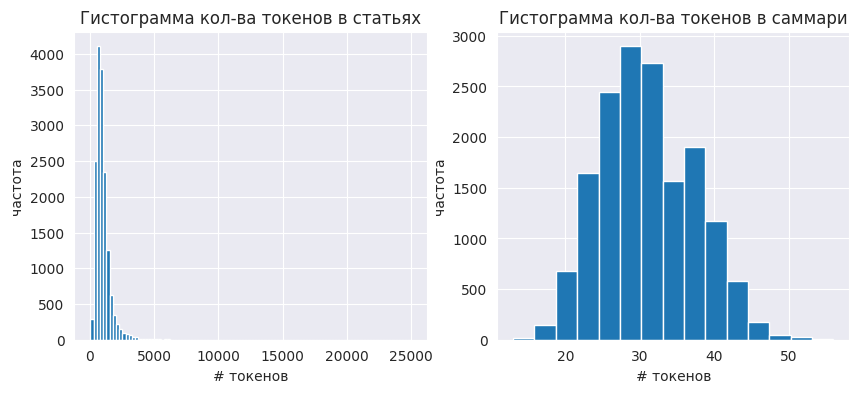

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('Гистограмма кол-ва токенов в статьях')
plt.hist(data['text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота')

plt.subplot(122)
plt.title('Гистограмма кол-ва токенов в саммари')
plt.hist(data['summary_num_tok'], bins=15)
plt.xlabel('# токенов')
plt.ylabel('частота');

квантиль 0.995: 4228


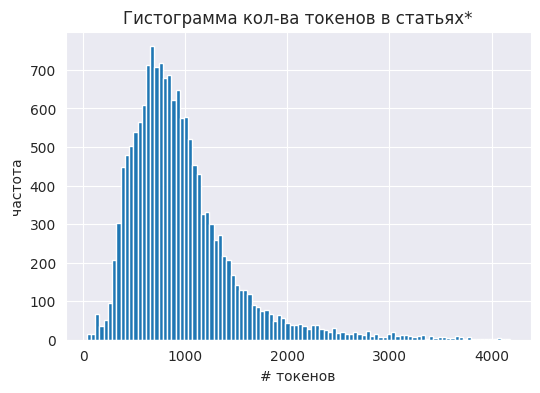

In [ ]:
# ого, похоже у них работают фанаты Льва Николаевича...

# квантиль 0.995:
q995 = round(data['text_num_tok'].quantile(0.995))
print('квантиль 0.995:', q995)

# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(6, 4))
plt.title('Гистограмма кол-ва токенов в статьях*')
plt.hist(data.loc[mask, 'text_num_tok'], bins=100)
plt.xlabel('# токенов')
plt.ylabel('частота');

In [ ]:
# длинные статьи будут обрезаться при токенизации, поэтому не переживаем за них.
# посмотрим на самые короткие:
q01 = round(data['text_num_tok'].quantile(0.01))
print('квантиль 0.01:', q01)
print()

mask = data['text_num_tok'] <= q01
short_texts = data.loc[mask, ['text']].values.tolist()

# выберем 15 рандомных 'коротышей':
random_idx = np.random.choice(np.arange(len(short_texts)), size=15 ,replace=False)
for i in random_idx:
  print(short_texts[i][0])
  print()

квантиль 0.01: 227

Фиксируем последние трансферные слухи, связанные в сезоном-2021 Формулы-1. По-прежнему неспокойно в царстве «Ред Булл», а вот в «Альфа Ромео» определились, сохранив прежний состав. Теперь мы близки и к объявлению дуэта пилотов «Хааса», где ждут Никиту Мазепина и Мика Шумахера.
Уже почти семикратный чемпион мира Льюис Хэмилтон никак не может найти время, чтобы всё обсудить с Тото Вольфом и подписать контракт на следующий сезон — это тоже рождает различные слухи, тем более с учётом того, что место в «Уильямсе» внезапно потеряет воспитанник «Мерседеса» Джордж Расселл. А вот в «Альфа Таури» подтвердили, что Пьер Гасли никуда не перейдёт.
Версия от 30 октября 2020 года
Свежие изменения в таблице выделены курсивом.

6 мая в московском дворце спорта «Динамо» на улице Лавочкина начнутся матчи «Финала шести» мужской волейбольной Суперлиги. Безоговорочным фаворитом считается казанский «Зенит», который неделю назад вбил в площадку всех соперников в римском «Финале четырёх» Лиг

In [ ]:
# короткие статьи выглядят нормально.

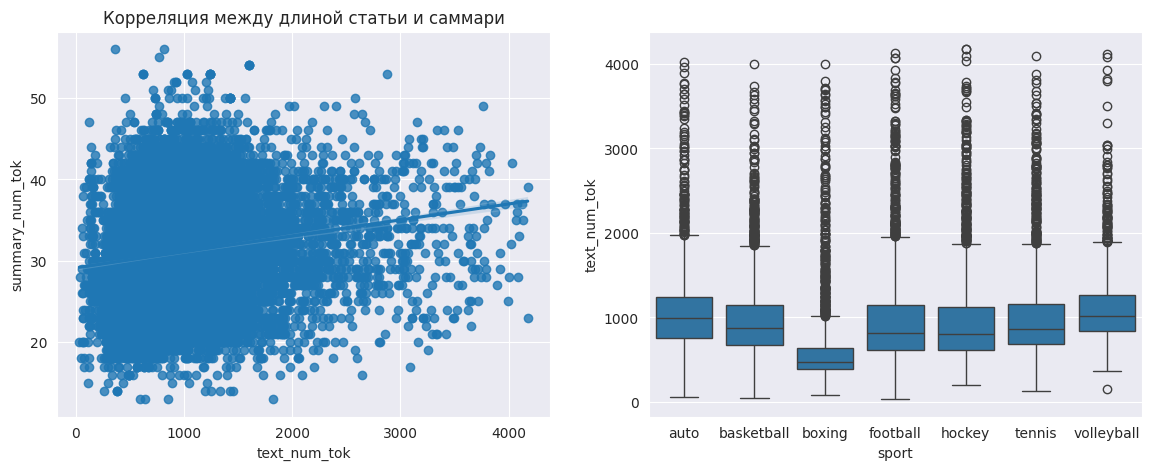

In [ ]:
# тепер, посмотрим на корреляцию между длиной статьи и саммари:
# исключим лонгриды:
mask = data['text_num_tok'] <= q995

plt.figure(figsize=(14, 5))
ax1 = plt.subplot(121)
sns.regplot(data=data[mask],
            x='text_num_tok',
            y='summary_num_tok',
            ax=ax1)
plt.title('Корреляция между длиной статьи и саммари')

# длина статьи в разрезе по видам спорта:
ax2 = plt.subplot(122)
sns.boxplot(data=data[mask],
            x='sport',
            y='text_num_tok',
            ax=ax2);

In [ ]:
# корреляция присутствует, но не очень сильная
# по каждому виду спорта встречаются весьма длинные статьи
# в целом, про бокс статьи существенно короче

In [ ]:
# теперь, соберем все символы встречающиеся в текстах:
all_chars = set()  # все символы

for txt in data['text'].values:
  chars = set(txt)
  all_chars.update(chars)

for txt in data['summary'].values:
  chars = set(txt)
  all_chars.update(chars)

In [ ]:
print('всего символов:', len(all_chars))

всего символов: 588


In [ ]:
# красота, давайте посмотрим на них:
all_chars

{'\n',
 '\r',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '~',
 '\xa0',
 '¡',
 '£',
 '©',
 '«',
 '¬',
 '\xad',
 '¯',
 '°',
 '²',
 '·',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 'É',
 'Ë',
 '×',
 'Ü',
 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ë',
 'í',
 'ñ',
 'ó',
 'ô',
 'õ',
 'ö',
 '÷',
 'ú',
 'ü',
 'ė',
 'ĸ',
 'Ł',
 'ł',
 'Š',
 'ū',
 'ų',
 'ž',
 '́',
 '̆',
 '̶',
 'ε',
 'ι',
 'κ',
 'ο',
 'ρ',
 'ς',
 'Ё',
 'Ѕ',
 'Ї',
 'Ј',
 'Џ',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 

In [ ]:
# ого, сколько смайликов. Посмоторим как LLM'ки вывезут все это дело.

### dataset:

In [ ]:
import datasets

In [ ]:
# данные будут в формате Dataset:
dataset = datasets.Dataset.from_pandas(data.loc[:, ['text', 'summary']])
dataset = dataset.shuffle(seed=9)

In [ ]:
# разделим на train/eval части:
dataset = dataset.train_test_split(test_size=0.15, shuffle=True, seed=11)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 13639
    })
    test: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 2408
    })
})

## качество на baseline
### в качетве baseline предсказания выберем первые 3 предложения из статьи (prediction) и сравних с саммари (gold standard)

In [ ]:
def get_baseline_preds(examples):
  # первые 3 предложения + разделитель '\n' между ними (метрики требуют)
  base_preds = ['\n'.join(nltk.sent_tokenize(doc)[:3]) for doc in examples['text']]
  # разделитель '\n' между предложениями в саммери (метрики требуют)
  base_true = ['\n'.join(nltk.sent_tokenize(doc)) for doc in examples['summary']]

  return {'base_preds': base_preds, 'base_true': base_true}

base_results =  dataset['test'].map(get_baseline_preds, batched=True)

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [ ]:
# вот что получилось:
base_results['base_preds'][:4]

['Для «Челси» 2022-й стал поворотным: спустя столько лет Роман Абрамович был вынужден искать для клуба нового владельца.\nПо итогам всех отборов им стал консорциум американца Тодда Боули.\nСделка по поглощению состоялась в мае, и с тех пор клуб проходит через сложный процесс трансформации – начиная с перестановок в руководстве и заканчивая пересмотром вектора развития команды.',
 'Шестой этап Формулы-1 — в непростительно субъективных оценках автора.\nВторая подряд превосходная гонка в исполнении немца.\nАккуратная работа с резиной на первом отрезке окупилась и позволила пробиться в топ-6, ну а затем Феттель прорвался на вторую строчку, опередив Леклера и Гасли.',
 'До начала Гран-при России Формулы-1, который уже в шестой раз пройдёт на «Сочи Автодроме», осталось всего несколько дней.\nУ настоящего болельщика уже забронированы авиабилеты и жильё.\nЕсли же нет — срочно торопитесь!',
 'Посмотреть все события 30 июня в Матч-центре «Чемпионата».\nВремя в материале — по Москве.\nПрограмма к

In [ ]:
# метрики качества: rouge и meteor
# качество для baseline:
result = rouge_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true'], use_stemmer=True)
result.update(meteor_metric.compute(predictions=base_results['base_preds'], references=base_results['base_true']))

{k: round(100*v, 4) for k, v in result.items()}

{'rouge1': 12.8478,
 'rouge2': 2.4539,
 'rougeL': 12.6174,
 'rougeLsum': 12.7442,
 'meteor': 17.9148}

In [ ]:
# будем сравнивать результаты mT5/ruBart с этими показателями

### выбор модели:

In [ ]:
# models:
model_checkpoint = "google/mt5-small"
#model_checkpoint = "IlyaGusev/mbart_ru_sum_gazeta"

### токенизация данных:

In [ ]:
from transformers import AutoTokenizer

# грузим токенизатор под выбранную модель:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# is fast:
tokenizer.is_fast

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting

True

In [ ]:
# сколько симвлов из all_chars будут непонятны для выбранного токенизатора:
unk_chars = [char for char in all_chars if '<unk>' in tokenizer.convert_ids_to_tokens(tokenizer(char)["input_ids"])]
print('неизвестных символов:', len(unk_chars))
unk_chars[:10]

всего: 32 символов


['🕕', '🟨', '🕤', '🕝', '🛎', '📯', '🕦', '🥱', '🕙', '⏸']

In [ ]:
#  для mT5 надо указать префикс, чтобы модель понимала какую задачу ей надо решать
if model_checkpoint in ["google/mt5-small", "google/mt5-base"]:
    prefix = "summarize: "  # 'суммировать: '  "summarize: "
else:
    prefix = ""

prefix

'summarize: '

In [ ]:
# токенизируем статьи и саммари:

# максимальное число токенов для статьи/саммари
max_input_length = 512 # 1024
max_target_length = 128

def preprocess_function(examples):
    # добавим prefix
    examples['text'] = [prefix + doc for doc in examples["text"]]
    # input_ids + attention_mask:
    model_inputs = tokenizer(examples['text'], max_length=max_input_length, truncation=True)

    # labels:
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# обработаем данные батчами:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/13639 [00:00<?, ? examples/s]

Map:   0%|          | 0/2408 [00:00<?, ? examples/s]

In [ ]:
# prefix + text:
for i in range(3):
  print(tokenized_datasets['train']['text'][i][:128])

summarize: На молодёжном чемпионате мира по хоккею в Галифаксе и Монктоне завершилась четвертьфинальная стадия. Групповой этап п
summarize: 8 января в матче 12-го тура российской женской Суперлиги краснодарское «Динамо» на своей площадке уверенно победило «
summarize: 20:45. Андрей Воронцевич после матча удивил сообщением о том, что тренерский штаб, помимо тренировочной работы, собра


In [ ]:
# удалим текстовые данные + __index_level_0__
tokenized_datasets = tokenized_datasets.remove_columns(['text', 'summary', '__index_level_0__'])

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13639
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2408
    })
})

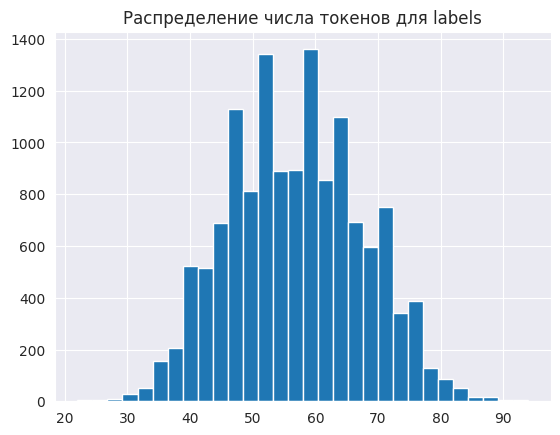

In [ ]:
# заценим распределение числа токенов в labels
# прикинем, сколько токенов генерить для предсказаний (max_new_tokens и min_new_tokens):
labels_num_tok = list(map(len, tokenized_datasets['train']['labels']))

plt.hist(labels_num_tok, bins=30)
plt.title('Распределение числа токенов для labels');

In [ ]:
# 35-80 токенов должно хватить, т.е. max_new_tokens=80, min_new_tokens=35

### импорт модели + data_collator

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, MT5ForConditionalGeneration #, Seq2SeqTrainingArguments, Seq2SeqTrainer

# импорт модели:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
#model = MT5ForConditionalGeneration.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# т.к. данные подаются в модель параллельно, они должны быть одной длины.
# добить input_ids/labels pad_token'ми до одной длины нам поможет data_collator
# + он заменит pad_token'ы на -100 в labels чтобы loss их игнорил, прям как ты свою бывшую (бывшего)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### dataloaders:

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE=8

In [ ]:
train_loader = DataLoader(tokenized_datasets['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)


test_loader = DataLoader(tokenized_datasets['test'],
                          batch_size=2*BATCH_SIZE,
                          shuffle=False,
                          collate_fn=data_collator)

In [ ]:
# работает ли?
for x_batch in test_loader:
  break
{k: v.shape for k,v in x_batch.items()}

{'input_ids': torch.Size([16, 512]),
 'attention_mask': torch.Size([16, 512]),
 'labels': torch.Size([16, 70]),
 'decoder_input_ids': torch.Size([16, 70])}

In [ ]:
# -100 в labels:
x_batch['labels'][:2]

tensor([[  4716,  19340,    433, 145524,    507, 101678,  15566,    279,    259,
            668,  10994,    401,  12601,  10263,    260,  32452,   1633,  43325,
            946, 118289,   2007, 113722,    748,    315,    404, 220586,   4832,
           1836,    259,  15088,    259,   4150,  13703,   2007,  32409,   6148,
          63235,  98808,    259,    279,    892,    259,    324,  23390,   6824,
          27492, 163269,  20593,    260,      1,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100],
        [  3461,   1348,  45315,    261,  19973,   4599,   1436,    291,    259,
          52911,    817,  18361,    995,   1311,  11167,    661,    259,  15354,
           1285,    605,    309,    983,  55421,    657,    374,  96331,    264,
          16296,    259, 140839,    308,    260,    867,  91288,  19138,   4229,
          44829,   1008,  75149,    261,   

### метрики качества:

In [ ]:
# оценивать качество сгенерированного текста будем по двум метрикам: rouge и meteor

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Replace -100 in the predictions as we can't decode them.
    #predictions = [np.where(l != -100, l, tokenizer.pad_token_id) for l in predictions]
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = [np.where(l != -100, l, tokenizer.pad_token_id) for l in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Add mean generated length
    #prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    #result["gen_len"] = np.mean(prediction_lens)

    result.update(meteor_metric.compute(predictions=decoded_preds, references=decoded_labels))
    return {k: round(100*v, 4) for k, v in result.items()}

### model to GPU/CPU:

In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
# device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

### оценим кач-во модели без fine-tuning'а

In [ ]:
# оценим суммаризацию статей без дообучения

In [ ]:
# eval:
datasets = {'test': test_loader}
#_ = 0

model.eval()
for name, dataset in datasets.items():
  eval_pred = []
  eval_true = []
  for x_batch in tqdm(dataset):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                             max_new_tokens=80,
                             min_new_tokens=35,
                             num_beams=2)

    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break

  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))
  print(model_checkpoint)
  print(scores)

100%|██████████| 151/151 [04:58<00:00,  1.98s/it]


google/mt5-small
{'rouge1': 1.6009, 'rouge2': 0.3463, 'rougeL': 1.5889, 'rougeLsum': 1.6084, 'meteor': 5.9037}


In [ ]:
#                                    google/mt5-small:
# {'rouge1': 1.6009, 'rouge2': 0.3463, 'rougeL': 1.5889, 'rougeLsum': 1.6084, 'meteor': 5.9037}


In [ ]:
# примеры генерации текста на примере последнего батча:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
text_gen

['<extra_id_0> СКА снова в плей-офф. СКА снова в плей-офф. СКА снова в плей-офф. СКА снова в плей-офф',
 '<extra_id_0> и почему. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг. Рейтинг.',
 '<extra_id_0> и почему? Это и есть именно так. Это и есть именно так. Это и есть именно так.',
 '<extra_id_0> не зря. Читать далее → Читать далее → Читать далее → Читать далее → Читать далее → Читать далее →',
 '<extra_id_0> оказался лучшим результатом встречи с «Акроном». Футболисты «Спартак» перед матчем с «Акроном» снова',
 '<extra_id_0> на финал чемпионата мира по хоккею-2023 наступила пора решающих матчей. ФОТО: ИНТЕРНЕТ-ФОНД.РФ. <extra_id_9>',
 '<extra_id_0> точно. UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284 UFC 284',
 '<extra_id_0> Грин. Что хозяева стали: «Лейкерс» против 1 из 20 (55%). «Лейкерс» против 1 из 20 (55%).']

### fine-tuning модели:

In [ ]:
# optimizer:
optim = AdamW(params=model.parameters(), lr=3e-4, weight_decay=0.01)

In [ ]:
# scheduler:
# линейно уменьшаем темп обучения (lr)
N_epochs = 2
n_train_steps = len(train_loader) * (N_epochs + 1)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=n_train_steps)

In [ ]:
# train/eval loops:
loss_hist = [] # train loss history
#eval_loss_hist = [] # train loss history
N_samples_eval = len(test_loader)
N_samples_train = len(train_loader)

for epoch in range(1, N_epochs+1):
  train_loss = 0
  model.train()
  for x_batch in tqdm(train_loader):
    # to device:
    x_batch = {k: v.to(device) for k,v in x_batch.items()}

    optim.zero_grad()
    output = model(**x_batch)
    output['loss'].backward()
    # clip grads:
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optim.step()

    # get and save loss:
    loss = output['loss'].detach().cpu().item()
    loss_hist.append(loss)
    train_loss += loss

    # scheduler step:
    lr_scheduler.step()

  #_ = 0

  # eval:
  eval_pred = []
  eval_true = []
  model.eval()
  for x_batch in tqdm(test_loader):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model.generate(**{k: v for k,v in x_batch.items() if k in ('input_ids', 'attention_mask')},
                              max_new_tokens=80,
                              min_new_tokens=35,
                              num_beams=2
      )
    y_pred = output.cpu().numpy()
    y_true = x_batch['labels'].cpu().numpy()
    eval_pred.extend(y_pred)
    eval_true.extend(y_true)

    #if _ == 50:
    #  break
  # evaluate metrics:
  scores = compute_metrics((eval_pred, eval_true))

  print(f'\nepoch: {epoch}')
  print(f'train loss: {round(train_loss/N_samples_train, 5)}')
  print(scores)
  print()

100%|██████████| 151/151 [06:00<00:00,  2.39s/it]



epoch: 1
train loss: 4.87551
{'rouge1': 5.2121, 'rouge2': 1.2947, 'rougeL': 5.213, 'rougeLsum': 5.1966, 'meteor': 12.1607}



100%|██████████| 151/151 [06:12<00:00,  2.47s/it]



epoch: 2
train loss: 3.80835
{'rouge1': 5.4517, 'rouge2': 1.1386, 'rougeL': 5.4611, 'rougeLsum': 5.4181, 'meteor': 13.098}



In [ ]:
# качество суммаризации очень не очень, но прогресс, в сравнении с тем что было до fine-tuning'а, есть))

In [ ]:
#                                          google/mt5-small:
# epoch: 1
# train loss: 4.87551
# {'rouge1': 5.2121, 'rouge2': 1.2947, 'rougeL': 5.213, 'rougeLsum': 5.1966, 'meteor': 12.1607}

# epoch: 2
# train loss: 3.80835
# {'rouge1': 5.4517, 'rouge2': 1.1386, 'rougeL': 5.4611, 'rougeLsum': 5.4181, 'meteor': 13.098}

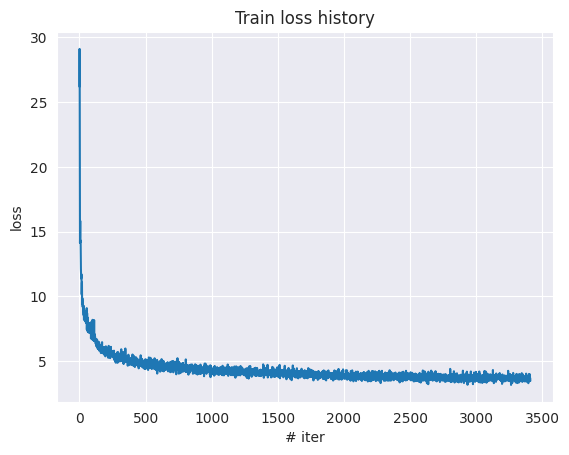

In [ ]:
plt.plot(loss_hist)
plt.title('Train loss history')
plt.xlabel('# iter')
plt.ylabel('loss');

In [ ]:
# примеры генерации текста из последнего батча:
text_gen = tokenizer.batch_decode(y_pred, skip_special_tokens=True)

In [ ]:
# google/mt5-small:
text_gen

['«Динамо» и СКА всё равно не будет. В российском баскетболе и российском баскетболе и российском баскетболе и российском баскетболе.',
 '«Зенит» выиграл лучший трансфер в истории «Зенита». Португалец в истории «Зенита» в истории «Зенита».',
 '«Всё важно». Российские звезды уже не стали лучшими. Российские звезды уже не смогли побить рекорд Гретцки.',
 '«Альфа Таури» и «Феррари» и «Феррари» и «Феррари» и «Феррари» и «Уильямс» и «Уильямс» и «Уильямс» и «Уильямс» и «Уильямс» и «Уильямс»',
 '«Спартак» выбил красно-белых из Кубка России. «Спартак» снова выбил красно-белых из Кубка России. «Спартак» продолжает подготовку к новому сезону РПЛ.',
 'В финале чемпионата мира по хоккею – 2023. Что происходит на ЧМ-2023? Что происходит на ЧМ-2023? Что происходит на ЧМ-2023?',
 '«Уайт» и Волкановски уже получил $ 1,2 млн. Ислам Махачев и Волкановски уже не смогли сделать деньги.',
 '«Голден Стэйт» выиграл в финале плей-офф НХЛ. «Лейкерс» выиграли в плей-офф НХЛ. «Голден Стэйт» выиграл в финале плей

In [ ]:
# сделать больше эпох, обрезать градиенты, подобрать гиперпараметры оптимизатора и scheduler'a ...
# To be continued...